### Variable to calculate: Mean AMOC

## Notebook for calculating GCB 2023 evaluation metric: Mean AMOC, maximum at 26N


## Step 1, calculate AMOC using CDFtools

    ### process annotation

    `module add gcc/10.3.0`

    `module add netcdf/4.7.4/gcc`

    toolbox is here: `cd /gpfs/home/mep22dku/cdftools`

    need to symlink orca meshmask:
bash 
    do  `bash link_tommask.sh`

    bashscript for running the toolbox is in `overturning_TOM.sh` in the toolbox directory (change model name!)
    it puts results in `/gpfs/home/mep22dku/cdftools/MOCresults` with name of run in filename

#### AMOC references

https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019RG000644

https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2015RG000493

when a single-value AMOC number is required, the maximum at 26N is meant. 


### Step 2, open AMOC files as mfdataset, calculte max at 26 and save file. 


In [11]:
%reset

In [12]:
import numpy as np
from cmocean import cm
import matplotlib.pyplot as plt
import xarray as xr
import sys

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

## step 2: concatenate and get maximum amoc

In [13]:


def make_yearlist(yrst, yrend, tr, baseDir = '/gpfs/home/mep22dku/cdftools/MOCresults/'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        tyr = yrs[i]
        ty = f'{baseDir}{tr}_1m_{tyr}0101*MOC.nc'
        t2 = glob.glob(ty)
        ylist.append(t2[0])
    return ylist

def get_max_amoc(moc_dataset):

    atl_at_26 = np.squeeze(moc_dataset.zomsfatl.sel(y=94).values)
    tshape = np.shape(atl_at_26)
    len_ts = tshape[0]

    max_atl = np.zeros(len_ts)

    for i in range(0,len(max_atl)):
        max_atl[i] = np.nanmax(atl_at_26[i,:])
        
    return max_atl


## change A, B, C, D simulations here if running for a different set of models (have to have MOC already calculated in step 1 above)

In [14]:
GEA0_moc = make_yearlist(1959, 2023, 'TOM12_TJ_R4A0')
GEB0_moc = make_yearlist(1959, 2023, 'TOM12_TJ_R4B0')
GEC0_moc = make_yearlist(1959, 2023, 'TOM12_TJ_R4C0')
GED0_moc = make_yearlist(1959, 2023, 'TOM12_TJ_R4D0')

GEA0_mocdat = xr.open_mfdataset(GEA0_moc) 
GEB0_mocdat = xr.open_mfdataset(GEB0_moc) 
GEC0_mocdat = xr.open_mfdataset(GEC0_moc) 
GED0_mocdat = xr.open_mfdataset(GED0_moc) 

GEA0_max_amoc = get_max_amoc(GEA0_mocdat)
GEB0_max_amoc = get_max_amoc(GEB0_mocdat)
GEC0_max_amoc = get_max_amoc(GEC0_mocdat)
GED0_max_amoc = get_max_amoc(GED0_mocdat)

In [15]:
print(GED0_mocdat.nav_lat[0,94,0].values)

26.055023


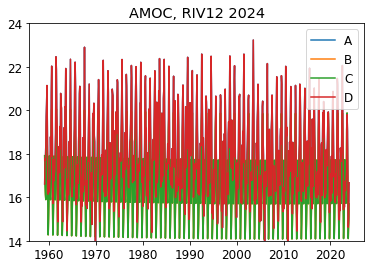

In [16]:
nicetime  = GEA0_mocdat.indexes['time_counter'].to_datetimeindex()
plt.plot(nicetime, GEA0_max_amoc, label = 'A')
plt.plot(nicetime, GEB0_max_amoc, label = 'B')
plt.plot(nicetime, GEC0_max_amoc, label = 'C')
plt.plot(nicetime, GED0_max_amoc, label = 'D')
plt.title('AMOC, RIV12 2024')
plt.ylim([14,24])
plt.legend()

In [17]:
import arrow

def make_amoc_nc(nicetime, tdat, simulationID, yrFrom = 1959, yrTo = 2023):

    utc = arrow.utcnow()
    timestamp = utc.format('YYYYMMDD')
    resultsdir = '/gpfs/data/greenocean/GCB/GCB2024/submissionData2024/RIV12_R4A-D0/Tier1/'
    parm = 'AMOC'
    outputFile = f'{resultsdir}{parm}_PlankTOM_{simulationID}_1_gr_{yrFrom}-{yrTo}_v{timestamp}.nc'
    data_vars = {'AMOC':(['TIME'], tdat,
    {'units': 'Sv',
    'long_name':'Atlantic Meridional Overturning Circulation'}),
    }
    # define coordinates
    coords = {'TIME': (['TIME'], nicetime)}
    # define global attributes
    attrs = {'made in':'/gpfs/data/greenocean/GCB/GCB2024/scripts/makeAMOC_RIV12.ipynb',
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    ds.to_netcdf(outputFile)
    


In [18]:
savehorse = True
if savehorse:
    
    make_amoc_nc(nicetime, GEA0_max_amoc, 'A')
    make_amoc_nc(nicetime, GEB0_max_amoc, 'B')
    make_amoc_nc(nicetime, GEC0_max_amoc, 'C')
    make_amoc_nc(nicetime, GED0_max_amoc, 'D')

## check that plotted values make sense!

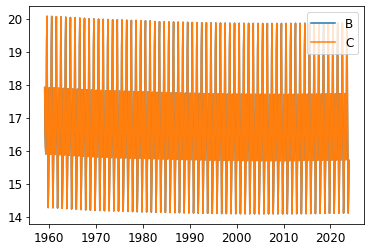

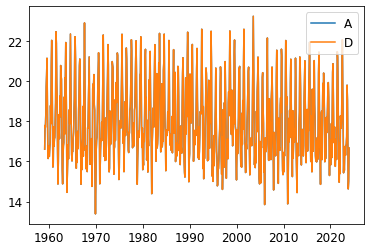

In [19]:

w = xr.open_dataset(glob.glob('/gpfs/data/greenocean/GCB/GCB2024/submissionData2024/RIV12_R4A-D0/Tier1/AMOC_PlankTOM_A_1_gr_1959-2023_*.nc')[0])
w2 = xr.open_dataset(glob.glob('/gpfs/data/greenocean/GCB/GCB2024/submissionData2024/RIV12_R4A-D0/Tier1/AMOC_PlankTOM_B_1_gr_1959-2023_*.nc')[0])
w3 = xr.open_dataset(glob.glob('/gpfs/data/greenocean/GCB/GCB2024/submissionData2024/RIV12_R4A-D0/Tier1/AMOC_PlankTOM_C_1_gr_1959-2023_*.nc')[0])
w4 = xr.open_dataset(glob.glob('/gpfs/data/greenocean/GCB/GCB2024/submissionData2024/RIV12_R4A-D0/Tier1/AMOC_PlankTOM_D_1_gr_1959-2023_*.nc')[0])

plt.figure()
#plt.plot(w.TIME, w.AMOC, label = 'A')
plt.plot(w.TIME, w2.AMOC, label = 'B')
plt.plot(w.TIME, w3.AMOC, label = 'C')
#plt.plot(w.TIME, w4.AMOC, label = 'D')
plt.legend()


plt.figure()
plt.plot(w.TIME, w.AMOC, label = 'A')
#plt.plot(w.TIME, w2.AMOC, label = 'B')
#plt.plot(w.TIME, w3.AMOC, label = 'C')
plt.plot(w.TIME, w4.AMOC, label = 'D')
plt.legend()